In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [58]:
L = 1.
NX = NY = 64
X_START = 0.
X_END = L
Y_START = 0.
Y_END = L
sin = jnp.sin
cos = jnp.cos
pi = jnp.pi
TOL = 1e-2
init_rms = 1e5

In [59]:
x = jnp.linspace(X_START, X_END, NX + 1)
y = jnp.linspace(Y_START, Y_END, NY + 1)
X, Y = jnp.meshgrid(x, y)

In [60]:
dx = x[1] - x[0]
dy = y[1] - y[0]

In [61]:
d = -(2/dx**2 + 2/dy**2)

In [62]:
u = jax.jit(lambda x, y: (x**2 - 1.)*(y**2 - 1.))
f = jax.jit(lambda x, y: -2.*(2. - x**2 - y**2))

In [63]:
U = u(X, Y)
F = f(X, Y)

In [64]:
u_init = U.at[1:-1,1:-1].set(0)

In [73]:
index_list = jnp.asarray([(i, j) for i in jnp.arange(NX+1) for j in jnp.arange(NX+1)])

In [127]:
@jax.jit
def gauss_siedel_iter(u, index_list, f, dx, dy, row_size, col_size):
    
    
    d = -2. * (1/dx**2 + 1/dy**2)

    def node_compute(i, j, u, f, dx, dy, d):
        u_ijm1, u_ij, u_ijp1, u_im1j, u_ip1j, f_ij = u[i,j - 1], u[i,j],  u[i,j + 1], u[i - 1,j], u[i + 1,j], f[i,j]
        r_ij = f_ij - (u_ijp1 - 2*u_ij + u_ijm1)/dx**2 - (u_ip1j - 2*u_ij + u_im1j)/dy**2
        return u_ij + r_ij/d
    
    def scan_func(carry, idx):
        i, j = idx
        u_updated = carry
        u_update_val = jax.lax.cond((i == 0) | (j == 0) | (jnp.mod(i, row_size - 1) == 0) | (jnp.mod(j, col_size - 1) == 0),\
                                    lambda u: u[i,j],\
                                    lambda u: node_compute(i, j, u, f, dx, dy, d),\
                                    u_updated)
        
        u_updated = u_updated.at[i,j].set(u_update_val)
        return u_updated, None
    
    return jax.lax.scan(scan_func, u, index_list)[0]      

In [132]:
gs_while_body_func = lambda u: gauss_siedel_iter(u, index_list=index_list, f=F, dx=dx, dy=dy, row_size=NX+1, col_size=NY+1)
gs_while_cond_func = lambda u: jnp.average(jnp.absolute(u - U)) > TOL

In [133]:
u_num = jax.lax.while_loop(gs_while_cond_func, gs_while_body_func, u_init)

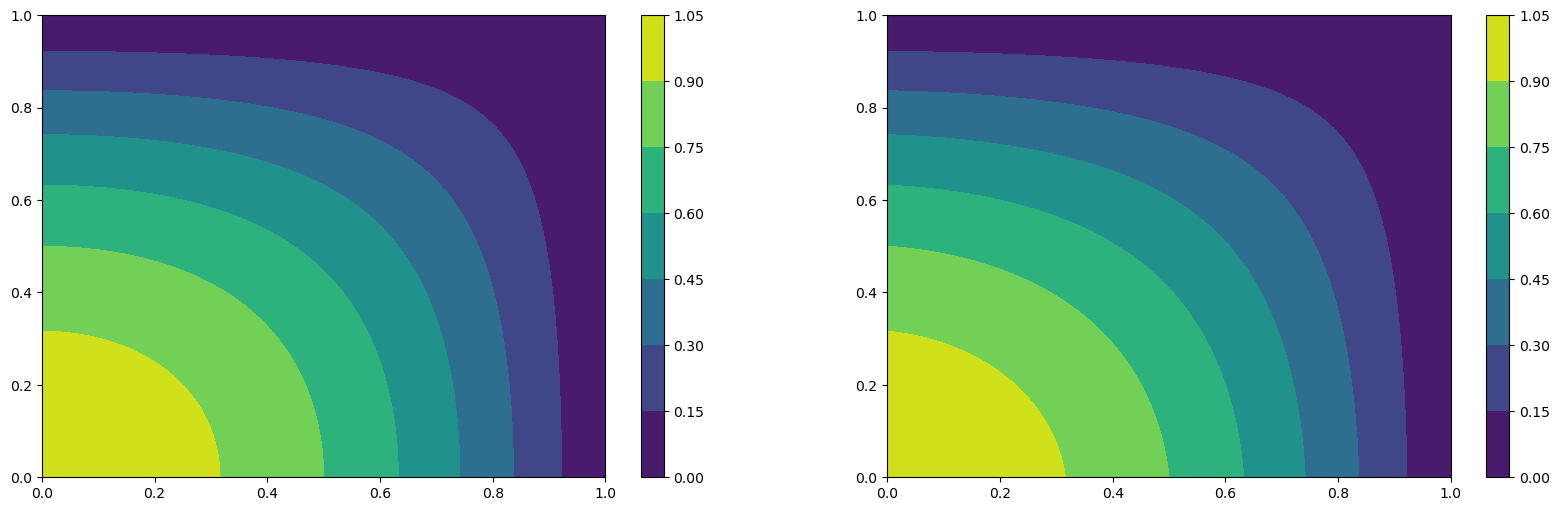

In [134]:
fig, axs = plt.subplots(1,2, figsize=(20, 6))
true = axs[0].contourf(X, Y, U)
num = axs[1].contourf(X, Y, u_num)

fig.colorbar(true)
fig.colorbar(num)
plt.show()